In [1]:
import sys

sys.path.append("../python")

import math
import matplotlib.pyplot as plt
from preprocess_data import EigenfacesDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

torch.manual_seed(315)

In [2]:
NUM_EPOCHS = 10
BATCH_SIZE = 20
LEARNING_RATE = 1e-3
SCALE=4

In [3]:
normalize_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])
eigenfaces_dataset = EigenfacesDataset(
    data_dir='../data',
    label='head_position',
    transform=normalize_transform)
trainset, testset = random_split(
    eigenfaces_dataset, [BATCH_SIZE * 10, len(eigenfaces_dataset) - BATCH_SIZE * 10])

In [4]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE)

In [5]:
def train(net, train_loader, test_loader,
          num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
          compute_accs=False):
    """
    This function trains the given network on the training data for the given number of epochs.
    If compute_accs is true, evaluates the train and test accuracy of the network at the end of
    each epoch.

    Args:
        net: The neural network to train
        train_loader, test_loader: The pytorch dataset loaders for the trainst and testset
        num_epochs: The number of times to loop over the batches in train_loader
        learning_rate: The learning rate for the optimizer
        compute_accs: A bool flag for whether or not this function should compute the train and test
                      accuracies at the end of each epoch. This feature is useful for visualizing
                      how the model is learning, but slows down training time.
    Returns:
        The train and test accuracies if compute_accs is True, None otherwise
    """
    # First initialize the criterion (loss function) and the optimizer
    # (algorithm like gradient descent). Here we use a common loss function for multi-class
    # classification called the Cross Entropy Loss and the popular Adam algorithm.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_accs = []
    test_accs = []

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for images, labels in train_loader:   # Loop over each batch in train_loader

            # If you are using a GPU, speed up computation by moving values to the GPU
            if torch.cuda.is_available():
                net = net.cuda()
                images = images.cuda()
                labels = labels.cuda()
                
            optimizer.zero_grad()               # Reset gradient for next computation
            outputs = net(images)               # Forward pass: compute the output class given a image
            loss = criterion(outputs, labels)   # Compute loss: difference between the pred and true 
            loss.backward()                     # Backward pass: compute the weight
            optimizer.step()                    # Optimizer: update the weights of hidden nodes
            
            if batch_num % BATCH_SIZE == 0:
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')

            batch_num += 1

        if compute_accs:
            train_acc = accuracy(net, train_loader)
            test_acc = accuracy(net, test_loader)

            print(f'Epoch [{epoch}/{num_epochs}], ',
                  f'Train Accuracy {100 * train_acc:.2f}%, ',
                  f'Test Accuracy {100 * test_acc:.2f}%')
            
            train_accs.append(train_acc)
            test_accs.append(test_acc)

    if compute_accs:
        return train_accs, test_accs
    else:
        return None


def accuracy(net, data_loader):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification
    accuracy.

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    for images, labels in data_loader:
        if  torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count

    return correct / total


def plot_history(histories):
    """
    Given a series of training/test accuracies from training, plots them to visualize learning.

    Args:
        histories: A list of dictionaries storing information about each model trained.
                   Each dictionary should have the keys:
                        * train_accs: A list of train accuracies
                        * test_accs: A list of test accuracies.
    """
    plt.figure(figsize=(16,10))
    epochs = list(range(1, len(histories[0]['train_accs']) + 1))
    for model_history in histories:
      label = model_history['label']
      val = plt.plot(epochs, model_history['test_accs'],
                     '--', label=label + ' test')
      plt.plot(epochs, model_history['train_accs'], color=val[0].get_color(),
               label=label + ' train')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])

In [6]:
class OneConvolutionNet(nn.Module):
    def __init__(self, num_classes):
        super(OneConvolutionNet, self).__init__()
        kernel_size = 5
        out_channels = 25
        self.conv = nn.Conv2d(
            in_channels=1,
            out_channels=out_channels,
            kernel_size=kernel_size)
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2)
        self.linear = nn.LazyLinear(out_features=num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

class TwoConvolutionNet(nn.Module):
    def __init__(self, num_classes):
        super(TwoConvolutionNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=20,
            kernel_size=5)
        self.conv2 = nn.Conv2d(
            in_channels=20,
            out_channels=50,
            kernel_size=5)
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2)
        self.linear1 = nn.LazyLinear(out_features=25)
        self.linear2 = nn.LazyLinear(out_features=num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [7]:
def get_train_test_set(label):
    normalize_transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(0.5, 0.5)])
    eigenfaces_dataset = EigenfacesDataset(
        data_dir='../data',
        label=label,
        scale=SCALE,
        transform=normalize_transform)
    trainset, testset = random_split(
        eigenfaces_dataset, [BATCH_SIZE * 10, len(eigenfaces_dataset) - BATCH_SIZE * 10])
    return (eigenfaces_dataset, trainset, testset)

def make_net(label, net_name):
    eigenfaces_dataset, trainset, testset = get_train_test_set(label)
    if net_name == 'OneConvolutionNet':
        net = OneConvolutionNet(eigenfaces_dataset.num_classes)
    elif net_name == 'TwoConvolutionNet':
        net = TwoConvolutionNet(eigenfaces_dataset.num_classes)
    train_loader = DataLoader(trainset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE)
    return (net, train_loader, test_loader)

def run_models(net_name):
    labels = ['eye_state', 'facial_expression', 'head_position']
    histories = []
    for label in labels:
        net, train_loader, test_loader = make_net(label, net_name)
        train_history, test_history = train(
            net, train_loader, test_loader, 
            num_epochs=NUM_EPOCHS, 
            learning_rate=LEARNING_RATE, 
            compute_accs=True)
        histories.append({
            'label': label,
            'train_accs': train_history,
            'test_accs': test_history
        })

    plot_history(histories)

/Users/apple/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10],  Train Accuracy 49.50%,  Test Accuracy 50.24%
Epoch [2/10],  Train Accuracy 53.00%,  Test Accuracy 52.12%
Epoch [3/10],  Train Accuracy 75.50%,  Test Accuracy 67.69%
Epoch [4/10],  Train Accuracy 83.00%,  Test Accuracy 73.82%
Epoch [5/10],  Train Accuracy 85.00%,  Test Accuracy 75.71%
Epoch [6/10],  Train Accuracy 80.50%,  Test Accuracy 74.06%
Epoch [7/10],  Train Accuracy 82.00%,  Test Accuracy 75.24%
Epoch [8/10],  Train Accuracy 84.50%,  Test Accuracy 75.94%
Epoch [9/10],  Train Accuracy 85.50%,  Test Accuracy 77.59%
Epoch [10/10],  Train Accuracy 86.50%,  Test Accuracy 78.30%
Epoch [1/10],  Train Accuracy 25.50%,  Test Accuracy 24.53%
Epoch [2/10],  Train Accuracy 31.50%,  Test Accuracy 21.93%
Epoch [3/10],  Train Accuracy 43.00%,  Test Accuracy 20.99%
Epoch [4/10],  Train Accuracy 42.50%,  Test Accuracy 20.75%
Epoch [5/10],  Train Accuracy 48.00%,  Test Accuracy 20.99%
Epoch [6/10],  Train Accuracy 48.00%,  Test Accuracy 20.05%
Epoch [7/10],  Train Accuracy 51.00%,  

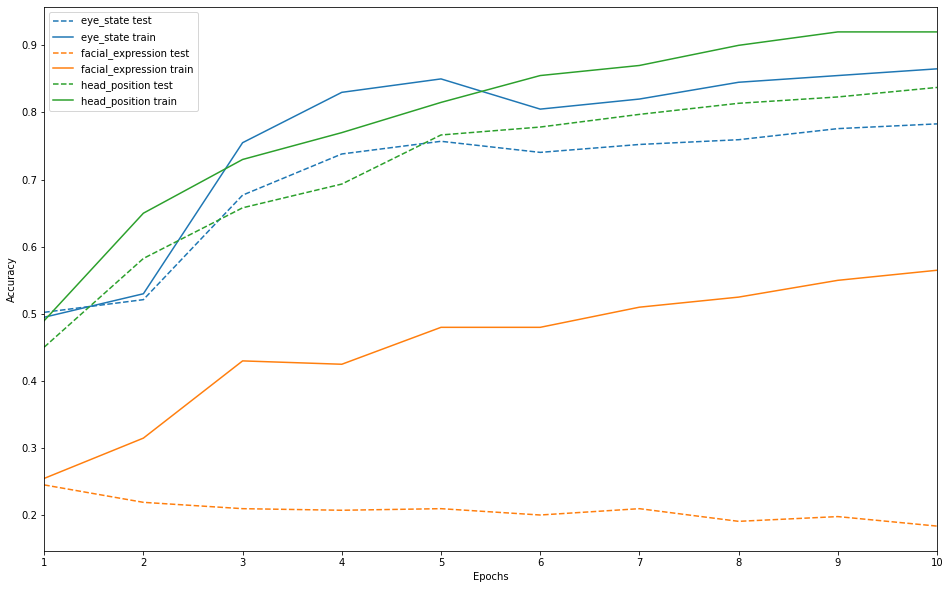

In [8]:
run_models('OneConvolutionNet')

Epoch [1/10],  Train Accuracy 71.50%,  Test Accuracy 59.91%
Epoch [2/10],  Train Accuracy 76.00%,  Test Accuracy 62.97%
Epoch [3/10],  Train Accuracy 76.50%,  Test Accuracy 63.68%
Epoch [4/10],  Train Accuracy 79.00%,  Test Accuracy 67.92%
Epoch [5/10],  Train Accuracy 81.50%,  Test Accuracy 68.87%
Epoch [6/10],  Train Accuracy 83.50%,  Test Accuracy 70.28%
Epoch [7/10],  Train Accuracy 86.50%,  Test Accuracy 73.11%
Epoch [8/10],  Train Accuracy 87.00%,  Test Accuracy 76.65%
Epoch [9/10],  Train Accuracy 87.50%,  Test Accuracy 78.07%
Epoch [10/10],  Train Accuracy 90.50%,  Test Accuracy 80.66%
Epoch [1/10],  Train Accuracy 27.00%,  Test Accuracy 24.53%
Epoch [2/10],  Train Accuracy 27.00%,  Test Accuracy 24.53%
Epoch [3/10],  Train Accuracy 26.00%,  Test Accuracy 23.82%
Epoch [4/10],  Train Accuracy 30.00%,  Test Accuracy 22.88%
Epoch [5/10],  Train Accuracy 30.00%,  Test Accuracy 20.99%
Epoch [6/10],  Train Accuracy 28.00%,  Test Accuracy 23.82%
Epoch [7/10],  Train Accuracy 34.00%,  

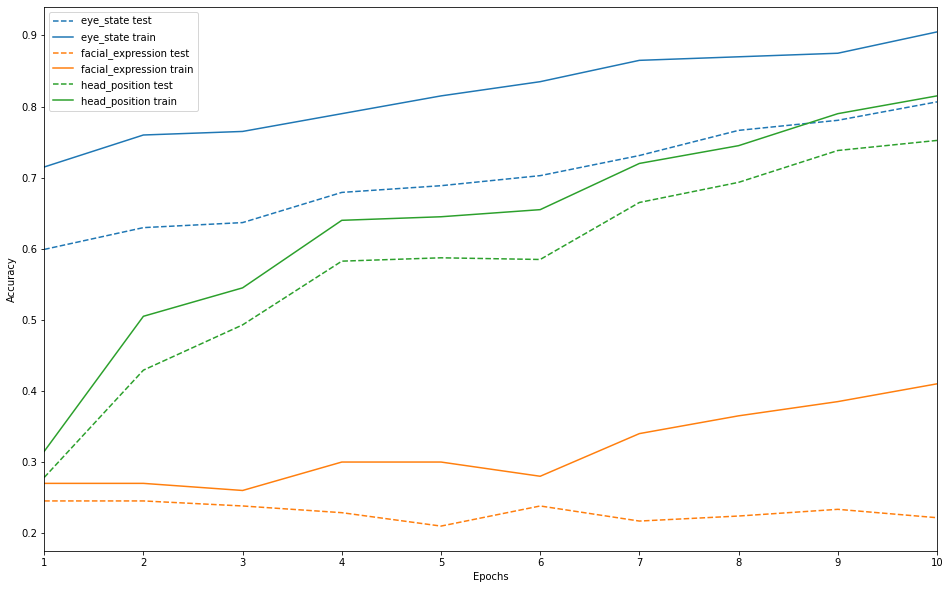

In [9]:
run_models('TwoConvolutionNet')